In [11]:
import mlrun
mlrun.mlconf = '/User/functions/{name}/function.yaml'

In [12]:
# nuclio: ignore
import nuclio

In [13]:
import os
import json
import importlib
from cloudpickle import load

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import TableArtifact, PlotArtifact

from mlrun.mlutils import plot_roc, plot_importance, gcf_clear

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


def test_classifier(
    context: MLClientCtx,
    models_path: str, 
    test_set: str,
    label_column: str,
    score_method: str = 'micro',
    plots_dest: str = ""
) -> None:
    """Test one or more classifier models against held-out dataset
    
    Using held-out test features, evaluates the peformance of the estimated model
    
    Can be part of a kubeflow pipeline as a test step that is run post EDA and 
    training/validation cycles
    
    :param context:         the function context
    :param models_path:     artifact models representing a file or a folder
    :param test_set:        test features and labels
    :param label_column:    column name for ground truth labels
    :param score_method:    for multiclass classification
    :param plots_dest:       dir for test plots
    """
    xtest = pd.read_parquet(str(test_set))
    ytest = xtest.pop(label_column)
    
    context.header = list(xtest.columns.values)
    def _eval_model(model):
        # enclose all except model
        ytestb = label_binarize(ytest, classes=ytest.unique())
        clf = load(open(model, "rb"))
        if callable(getattr(clf, "predict_proba")):
            y_score = clf.predict_proba(xtest.values)
            ypred = clf.predict(xtest.values)
            plot_roc(context, ytestb, y_score, key='roc', plots_dir=plots_dest)
        else:
            ypred = clf.predict(xtest.values) # refactor
            y_score = None
            
        gcf_clear(plt)
        metrics.plot_confusion_matrix(clf, xtest.values, ytest, 
                                      labels=ytest.unique(), normalize='true') 
        
        context.log_artifact(PlotArtifact("confusion", body=plt.gcf()), 
                             local_path=f"{plots_dest}/confusion.html")        
    
        if hasattr(clf, "feature_importances_"):
            plot_importance(context, clf, key=f"featimp")

        ytestb = label_binarize(ytest, classes=ytest.unique())

        if ytestb.shape[1] > 1:
            average_precision = metrics.average_precision_score(ytestb,
                                                                y_score,
                                                                average=score_method)
            context.log_result(f"rocauc", metrics.roc_auc_score(ytestb, y_score))
        else:
            average_precision = metrics.average_precision_score(ytestb,
                                                                y_score[:, 1],
                                                                average=score_method)
            context.log_result(f"rocauc", metrics.roc_auc_score(ytestb, y_score[:, 1]))

        context.log_result(f"avg_precscore", average_precision)
        context.log_result(f"accuracy", float(clf.score(xtest.values, ytest)))
        context.log_result(f"f1_score", metrics.f1_score(ytest, ypred,
                                                         average=score_method))
        if y_score is None:
            return y_score
        else:
            return ypred
    
    models_path = str(models_path)
    if models_path.endswith('.pkl'):
        _eval_model(models_path)
        
    else:
        for model in os.listdir(models_path):
            if model.endswith('.pkl'):
                y_hat = _eval_model(os.path.join(models_path, model))
                if y_hat.ndim == 1 or y_hat.shape[1] == 1:
                    score_names = ["yscore"]
                else:
                    score_names = ["yscore_" + str(x) for x in range(y_hat.shape[1])]
                df = pd.concat([xtest, ytest, pd.DataFrame(y_hat, columns=score_names)], axis=1)
                context.log_dataset("test_set_preds", df=df, format="parquet", index=False)

In [14]:
# nuclio: end-code

### save

In [15]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("test_classifier", kind="job", with_doc=True,
                      image="mlrun/ml-models")

# add metadata (for templates and reuse)
fn.spec.default_handler = "test_classifier"
fn.spec.description = "test a classifier using held-out or new data"
fn.metadata.categories = ["models", "testing"]
fn.metadata.labels = {"author": "yjb"}

fn.save()
fn.export("function.yaml")

[mlrun] 2020-04-06 12:17:45,656 saving function: test-classifier, tag: latest
[mlrun] 2020-04-06 12:17:45,853 function spec saved to path: function.yaml


## tests

In [16]:
from mlrun import import_function, mount_v3io, NewTask

func = import_function("hub://test_classifier").apply(mount_v3io())
# func = import_function("function.yaml").apply(mlrun.mount_v3io())

task_params = {
    "name" : "tasks - test classifier",
    "params": {
        # Ina pipeline setting, the models_path parameter would be the output of a training step
        "models_path"   : "/User/artifacts/models",
        "label_column"  : "labels"}}

### run locally

[mlrun] 2020-04-06 12:17:46,218 starting run tasks - test classifier uid=d441b6f582e1404c9b2852f9c5dbd13d  -> http://mlrun-api:8080


No handles with labels found to put in legend.


[mlrun] 2020-04-06 12:17:48,321 log artifact roc at /User/artifacts/roc.html, size: 27342, db: Y
[mlrun] 2020-04-06 12:17:49,524 log artifact confusion at /User/artifacts/confusion.html, size: 17452, db: Y
[mlrun] 2020-04-06 12:17:54,490 log artifact featimp at /User/artifacts/plots/featimp.html, size: 20422, db: Y
[mlrun] 2020-04-06 12:17:54,601 log artifact featimp-tbl at /User/artifacts/featimp-tbl.csv, size: 342, db: Y
[mlrun] 2020-04-06 12:17:55,601 log artifact test_set_preds at /User/artifacts/test_set_preds.parquet, size: 1184817, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...dbd13d,0,Apr 06 12:17:46,completed,tasks - test classifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-7c656d7bdf-bx992,test_set,models_path=/User/artifacts/modelslabel_column=labels,rocauc=0.29482656952329417avg_precscore=0.20080406631961104accuracy=0.9349f1_score=0.9349,rocconfusionfeatimpfeatimp-tbltest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run d441b6f582e1404c9b2852f9c5dbd13d --project default , !mlrun logs d441b6f582e1404c9b2852f9c5dbd13d --project default
[mlrun] 2020-04-06 12:17:55,909 run executed, status=completed


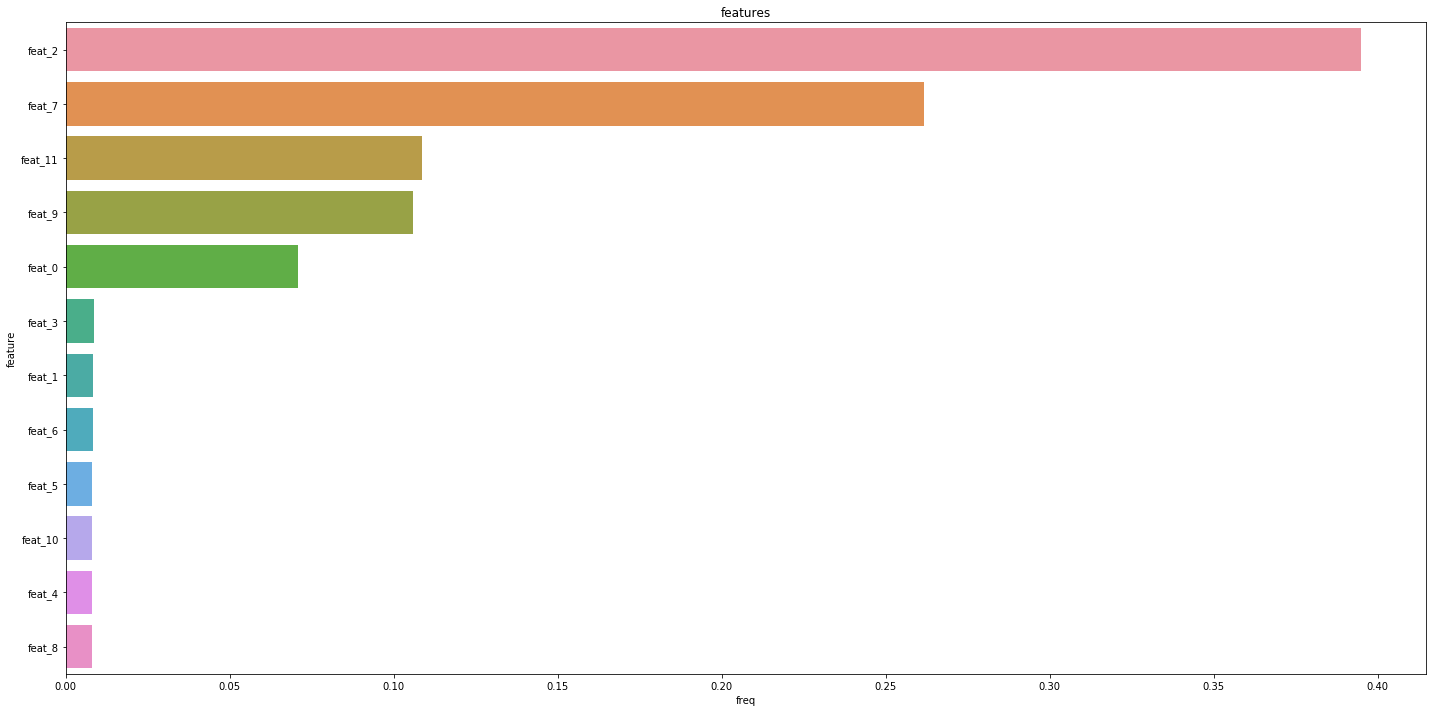

In [17]:
from mlrun import run_local
run = run_local(NewTask(**task_params),
                handler=test_classifier,
                inputs={"test_set":"/User/artifacts/test_set.parquet" },
                artifact_path="/User/artifacts")

In [18]:
pd.read_parquet('/User/artifacts/test_set_preds.parquet').head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,labels,yscore
0,-1.141668,0.287036,1.096003,-0.594811,-0.925244,0.446005,-0.576647,-0.270220,-0.175167,0.819868,0.395715,1.722689,1,1
1,0.879088,-0.750999,-0.418326,0.952288,0.583110,-0.292849,-1.022820,-0.858725,-0.874212,-1.302250,-0.451088,-0.728875,1,0
2,1.404489,-0.833069,-1.458406,0.038042,-0.288901,-0.155351,-1.540353,0.317745,-0.455204,-0.787406,-0.942335,-2.018683,2,2
3,1.744641,0.494283,-2.001257,-1.171488,-0.563341,-0.441931,-0.338920,-0.786973,0.924304,-0.407521,0.687303,-1.319063,0,0
4,0.359996,-1.849620,-0.559841,1.599725,-0.187700,1.841551,-0.083354,1.795251,-0.933251,-0.113059,1.804651,-1.873912,2,2


### remotely

In [ ]:
from mlrun import NewTask
run = func.run(NewTask(**task_params), 
               inputs={"test_set":"/User/artifacts/test_set.parquet" },
               artifact_path="/User/artifacts")